1. Типы шумов. Выбрать произвольное изображение. Получить
искаженные различными шумами изображения с помощью
функции imnoise() с отличными от значений по умолчанию
параметрами.

2. Низкочастотная фильтрация. Обработать полученные в
предыдущем пункте искаженные изображения фильтром
Гаусса и контргармоническим усредняющим фильтром с различными значениями параметра 𝑄.

3. Нелинейная фильтрация. Обработать полученные в первом
пункте искаженные изображения 

медианной, 
взвешенной медианной, 
ранговой
Винеровской фильтрациями 

при различных размерах маски и ее коэффициентов. Реализовать адаптивную медианную фильтрацию.

4. Высокочастотная фильтрация. Выбрать исходное изображение. Выделить границы фильтрами Робертса, Превитта, Собела, Лапласа, алгоритмом Кэнни.

**Типы шумов**

Цифровые изображения, полученные различными оптикоэлектронными приборами, могут содержать в себе разнообразные
искажения, обусловленные разного рода помехами, которые принято называть шумом. Шум на изображении затрудняет его 
обработку автоматическими средствами и, поскольку шум может иметь различную природу, для его успешного подавления 
необходимо определить адекватную математическую модель. Рассмотрим наиболее распространенные модели шумов. 

In [2151]:
import cv2
import skimage
import skimage.filters
import skimage.restoration
import scipy
import scipy.ndimage
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from numba import njit, jit
from math import *
import warnings
warnings.filterwarnings('ignore')
export_parallel = True
use_graph = False

In [2152]:
# Исходное изображение до наложения шума
image = cv2.cvtColor(cv2.imread("data/night_city.jpg"), cv2.COLOR_BGR2GRAY)
print(image.shape)

images_noised = {}

# Общая для всех зашумлённость
amount = 0.2
var = 0.2
mean = 0.0
lam = 20.0

(2074, 3782)


In [2153]:
# Исходное изображение до наложения шума
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

**Импульсный шум**

При импульсном шуме сигнал искажается выбросами с очень
большими отрицательными или положительными значениями малой длительностью и может возникать, например, из-за ошибок
декодирования. Такой шум приводит к появлению на изображении белых («соль») или черных («перец») точек, поэтому зачастую
называется точечным шумом. Для его описания следует принять
во внимание тот факт, что появление шумового выброса в каждом
пикселе 𝐼(𝑥,𝑦) не зависит ни от качества исходного изображения, ни
от наличия шума в других точках и имеет вероятность появления
𝑝, причем значение интенсивности пикселя 𝐼(𝑥,𝑦) будет изменено
на значение 𝑑 ∈ [0,255]

In [2154]:
# Наложение импульсного шума
image_noised_s_and_p = skimage.util.random_noise(image, mode="s&p", amount=amount, salt_vs_pepper=0.3)
image_noised_s_and_p = np.clip(image_noised_s_and_p, 0.0, 1.0)
image_noised_s_and_p = skimage.img_as_ubyte(image_noised_s_and_p)
images_noised["salt and pepper"] = image_noised_s_and_p.copy()

image_noised_all = image_noised_s_and_p

# Изображение после наложения импульсного шума
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_noised_s_and_p, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

**Аддитивный шум**

Аддитивный шум описывается следующим выражением:

𝐼𝑛𝑒𝑤(𝑥,𝑦) = 𝐼(𝑥,𝑦) + 𝜂(𝑥,𝑦),

где 𝐼𝑛𝑒𝑤 — зашумленное изображение, 
𝐼 — исходное изображение,
𝜂 — не зависящий от сигнала аддитивный шум с гауссовым или
любым другим распределением функции плотности вероятности.

**Мультипликативный шум**

Мультипликативный шум описывается следующим выражением:

𝐼𝑛𝑒𝑤(𝑥,𝑦) = 𝐼(𝑥,𝑦) · 𝜂(𝑥,𝑦),

где 𝐼𝑛𝑒𝑤 — зашумленное изображение, 𝐼 — исходное изображение, 𝜂
— не зависящий от сигнала мультипликативный шум, умножающий
зарегистрированный сигнал. В качестве примера можно привести 
зернистость фотопленки, ультразвуковые изображения и т.д. Частным случаем мультипликативного шума является спекл-шум, 
который появляется на изображениях, полученных устройствами с когерентным формированием изображений, например, 
медицинскими
сканерами или радарами. На таких изображениях можно отчетливо
наблюдать светлые пятна, крапинки (спеклы), которые разделены
темными участками изображения.

In [2155]:
# Наложение мультипликативного шума
image_noised_multi = skimage.util.random_noise(image, mode="speckle", var=var, mean=mean)
image_noised_multi = np.clip(image_noised_multi, 0.0, 1.0)
image_noised_multi = skimage.img_as_ubyte(image_noised_multi)
images_noised["speckle"] = image_noised_multi.copy()

image_noised_all = skimage.util.random_noise(image_noised_all, mode="speckle", var=var, mean=mean)
image_noised_all = np.clip(image_noised_all, 0.0, 1.0)
image_noised_all = skimage.img_as_ubyte(image_noised_all)

# Изображение после наложения мультипликативного шума
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_noised_multi, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

**Гауссов (нормальный) шум**

Гауссов шум на изображении может возникать в следствие недостатка освещенности сцены, высокой температуры и т.д. 
Модель шума широко распространена в задачах низкочастотной фильтрации изображений. 

In [2156]:
# Наложение Гауссова шума
image_noised_gaussian = skimage.util.random_noise(image, mode="gaussian", var=var, mean=mean)
image_noised_gaussian = np.clip(image_noised_gaussian, 0.0, 1.0)
image_noised_gaussian = skimage.img_as_ubyte(image_noised_gaussian)
images_noised["gaussian"] = image_noised_gaussian.copy()

image_noised_all = skimage.util.random_noise(image_noised_all, mode="gaussian", var=var, mean=mean)
image_noised_all = np.clip(image_noised_all, 0.0, 1.0)
image_noised_all = skimage.img_as_ubyte(image_noised_all)

# Изображение после наложения Гауссова шума
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_noised_gaussian, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

**Шум квантования**

Зависит от выбранного шага квантования и самого сигнала.
Шум квантования может приводить, например, к появлению ложных контуров вокруг объектов или убирать слабо 
контрастные детали на изображении. Такой шум не устраняется. Приближенно
шум квантования можно описать распределением Пуассона

In [2157]:
# Создание шума квантования с заданными параметрами распределения Пуассона
noise_poisson = np.random.poisson(lam=lam, size=image.shape) * (1.0 / 255.0)
noise_poisson = np.clip(noise_poisson, 1.0 / 255.0, 1.0)

# Наложение шума квантования
image_noised_poisson = skimage.util.random_noise(image, mode="localvar", local_vars=noise_poisson)
image_noised_poisson = np.clip(image_noised_poisson, 0.0, 1.0)
image_noised_poisson = skimage.img_as_ubyte(image_noised_poisson)
images_noised["poisson"] = image_noised_poisson.copy()

image_noised_all = skimage.util.random_noise(image_noised_all, mode="localvar", local_vars=noise_poisson)
image_noised_all = np.clip(image_noised_all, 0.0, 1.0)
image_noised_all = skimage.img_as_ubyte(image_noised_all)

# Изображение после наложения шума квантования
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_noised_poisson, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

In [2158]:
# Изображение после наложения всех шумов
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_noised_all, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

### 2 Низкочастотная фильтрация

Низкочастотные пространственные фильтры ослабляют высокочастотные компоненты (области с сильным изменением интенсивностей) и оставляют низкочастотные компоненты изображения
без изменений. Используются для снижения уровня шума и удаления высокочастотных компонент, что позволяет повысить точность
исследования содержания низкочастотных компонент. В результате применения низкочастотных фильтров получим сглаженное или
размытое изображение. Главными отличительными особенностями
являются:

1. неотрицательные коэффициенты маски;

2. сумма всех коэффициентов равна единице.

### 2.1 Фильтр Гаусса

In [2159]:
# Применеие фильтра Гаусса ко всем зашумлённым изображениям
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name)
        image_filtered = skimage.filters.gaussian(images_noised[image_name], sigma=4.0)
        image_filtered = np.clip(image_filtered, 0.0, 1.0)
        image_filtered = skimage.img_as_ubyte(image_filtered)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

### 2.2 Контргармонический усредняющий фильтр с различными значениями параметра 𝑄

In [2160]:
def counter_harmonic_mean_filter(image, kernel_size=3, Q=0):
    rows, cols = image.shape
    kernel_mid = kernel_size // 2
    kernel_k = 1 / pow(kernel_size, 2.0)
    
    image_bordered = cv2.copyMakeBorder(
        image,
        top=kernel_size // 2,
        bottom=kernel_size // 2 + kernel_size % 2,
        left=kernel_size // 2,
        right=kernel_size // 2 + kernel_size % 2,
        borderType=cv2.BORDER_REPLICATE,
        value=[mean, mean, mean]
    )
    
    image_float = np.clip(image / 255.0, 0.0, 1.0)
    image_bordered_float = np.zeros_like(image_bordered, dtype=np.float64)
    
    image_float_power = []
    for q in range(2):
        image_float_power.append(np.power(image_float, Q + q))
        image_float_power[q] = np.clip(image_float_power[q], 0.0, 10)
    for y in range(-kernel_mid, kernel_mid + kernel_size % 2):
        for x in range(-kernel_mid, kernel_mid + kernel_size % 2):
            image_bordered_float[kernel_mid + y:kernel_mid + rows + y,
            kernel_mid + x:kernel_mid + cols + x] += kernel_k * image_float_power[1] / image_float_power[0]
    image_bordered_float = np.clip(image_bordered_float, 0.0, 1.0)
    image = image_bordered_float[kernel_mid:rows+kernel_mid, kernel_mid:cols+kernel_mid] * 255.0
    return image.astype(np.uint8)

In [2161]:
kernel_size = 7
Q = -1.5
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = -1.5


In [2162]:
Q = -1.25
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = -1.25


In [2163]:
Q = -1.0
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = -1.0


In [2164]:
Q = -0.75
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = -0.75


In [2165]:
Q = -0.5
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = -0.5


In [2166]:
Q = -0.25
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = -0.25


In [2167]:
Q = 0.0
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 0.0


In [2168]:
Q = 0.25
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 0.25


In [2169]:
Q = 0.5
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 0.5


In [2170]:
Q = 0.75
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 0.75


In [2171]:
Q = 1.0
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 1.0


In [2172]:
Q = 1.25
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 1.25


In [2173]:
Q = 1.5
# Применеие Контргармонического усредняющего фильтра с различными значениями параметра 𝑄 
# ко всем зашумлённым изображениям
print(f"Q = {Q}")
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = counter_harmonic_mean_filter(images_noised[image_name], kernel_size=kernel_size, Q=Q)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

Q = 1.5


### 3 Нелинейная фильтрация.

Низкочастотные фильтры линейны и оптимальны в случае, когда имеет место нормальное распределение помех на цифровом
изображении. Линейные фильтры локально усредняют импульсные
помехи, сглаживая изображения. Для устранения импульсных помех лучше использовать нелинейные, например, медианные фильтры.

### 3.1 Медианный фильтр

In [2174]:
kernel = np.ones((11,11),np.float64)
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.median_filter(images_noised[image_name], footprint=kernel)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


### 3.2 Взвешенный медианный фильтр

In [2175]:
kernel = np.random.random(size=(11,11))
kernel /= np.max(kernel)
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.median_filter(images_noised[image_name], footprint=kernel)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

[[0.47822027 0.25285844 0.90333962 0.86494496 0.49588845 0.36027729
  1.         0.49360683 0.65608732 0.68384755 0.59540926]
 [0.52841917 0.29963793 0.37511307 0.27685139 0.66547545 0.43494542
  0.01193845 0.25130116 0.22660953 0.16332915 0.70105214]
 [0.03674872 0.60154214 0.05015359 0.52827081 0.19050212 0.36183084
  0.63939233 0.52317012 0.71346455 0.50799406 0.81792155]
 [0.8151167  0.38981371 0.1242986  0.51696615 0.95886654 0.38984167
  0.85358494 0.86809313 0.82571481 0.59749055 0.93966544]
 [0.67690976 0.03852485 0.03500549 0.73380326 0.38385886 0.6721598
  0.72694059 0.90058863 0.52937523 0.0755201  0.10220084]
 [0.73706117 0.84666466 0.96021529 0.51150789 0.33791999 0.58485643
  0.16712862 0.67415256 0.32058981 0.38018787 0.38335234]
 [0.8906748  0.41893313 0.21639908 0.31541535 0.68293443 0.82678411
  0.49353989 0.82923612 0.1033249  0.28295622 0.73406915]
 [0.98649117 0.26822461 0.06140783 0.3533006  0.40678255 0.49593588
  0.14585176 0.44236642 0.09624768 0.81838153 0.440

### 3.3 Ранговый фильтр

In [2176]:
rank = -25
kernel = np.ones((5,5),np.float64)
print(f"rank = {rank + 25}")
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.rank_filter(images_noised[image_name], footprint=kernel, rank=rank)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

rank = 0
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [2177]:
rank = -18
kernel = np.ones((5,5),np.float64)
print(f"rank = {rank + 25}")
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.rank_filter(images_noised[image_name], footprint=kernel, rank=rank)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

rank = 7
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [2178]:
rank = -12
kernel = np.ones((5,5),np.float64)
print(f"rank = {rank + 25}")
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.rank_filter(images_noised[image_name], footprint=kernel, rank=rank)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

rank = 13
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [2179]:
rank = -6
kernel = np.ones((5,5),np.float64)
print(f"rank = {rank + 25}")
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.rank_filter(images_noised[image_name], footprint=kernel, rank=rank)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

rank = 19
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


In [2180]:
rank = -1
kernel = np.ones((5,5),np.float64)
print(f"rank = {rank + 25}")
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = scipy.ndimage.rank_filter(images_noised[image_name], footprint=kernel, rank=rank)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

rank = 24
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


### 3.4 Фильтр Винера

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
salt and pepper, speckle, gaussian, poisson, 


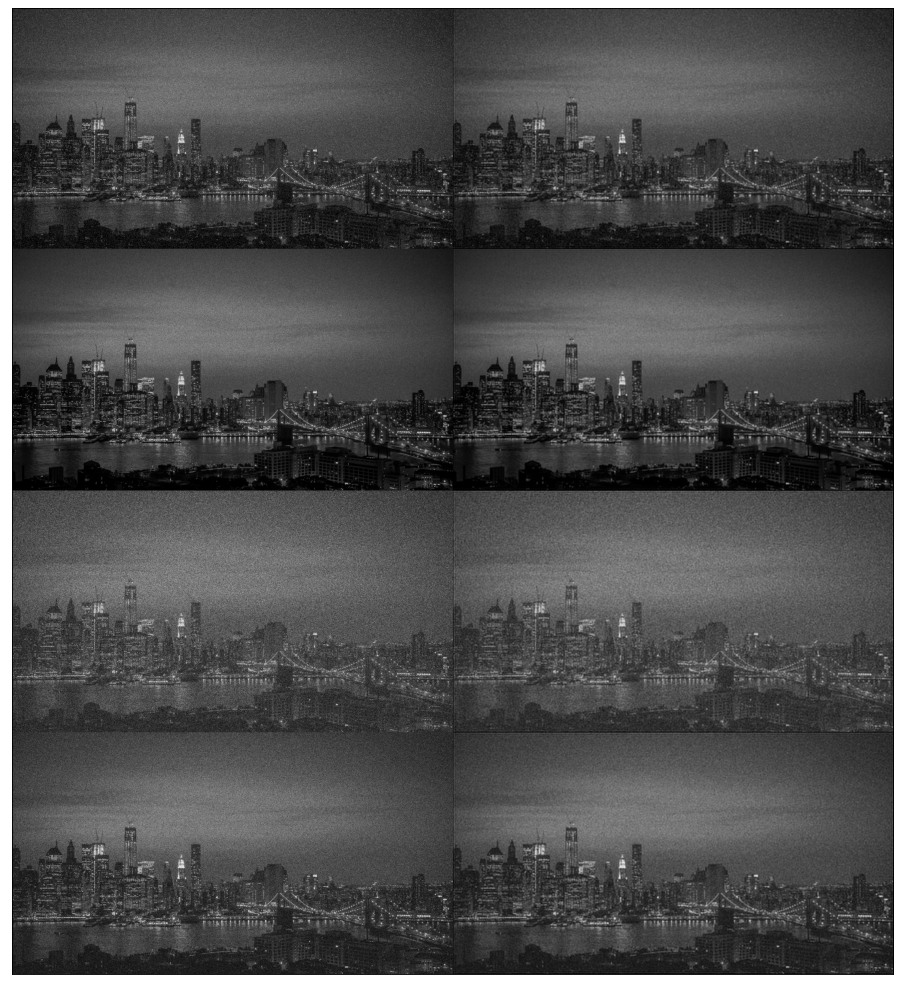

In [2181]:
use_graph = True
kernel = np.ones((15,15),np.float64)
print(kernel)
if use_graph:
    image_combined = None
    for image_name in images_noised.keys():
        print(image_name, end=', ')
        image_filtered = skimage.img_as_float64(images_noised[image_name])
        image_filtered = scipy.signal.convolve2d(image_filtered, kernel, 'same')
        image_filtered = skimage.restoration.wiener(image_filtered, kernel, 5.1e4)
        image_filtered = skimage.img_as_ubyte(image_filtered)
        image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
        if image_combined is None:
            image_combined = image_filtered
        else:
            image_combined = cv2.vconcat([image_combined, image_filtered])
    print()
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


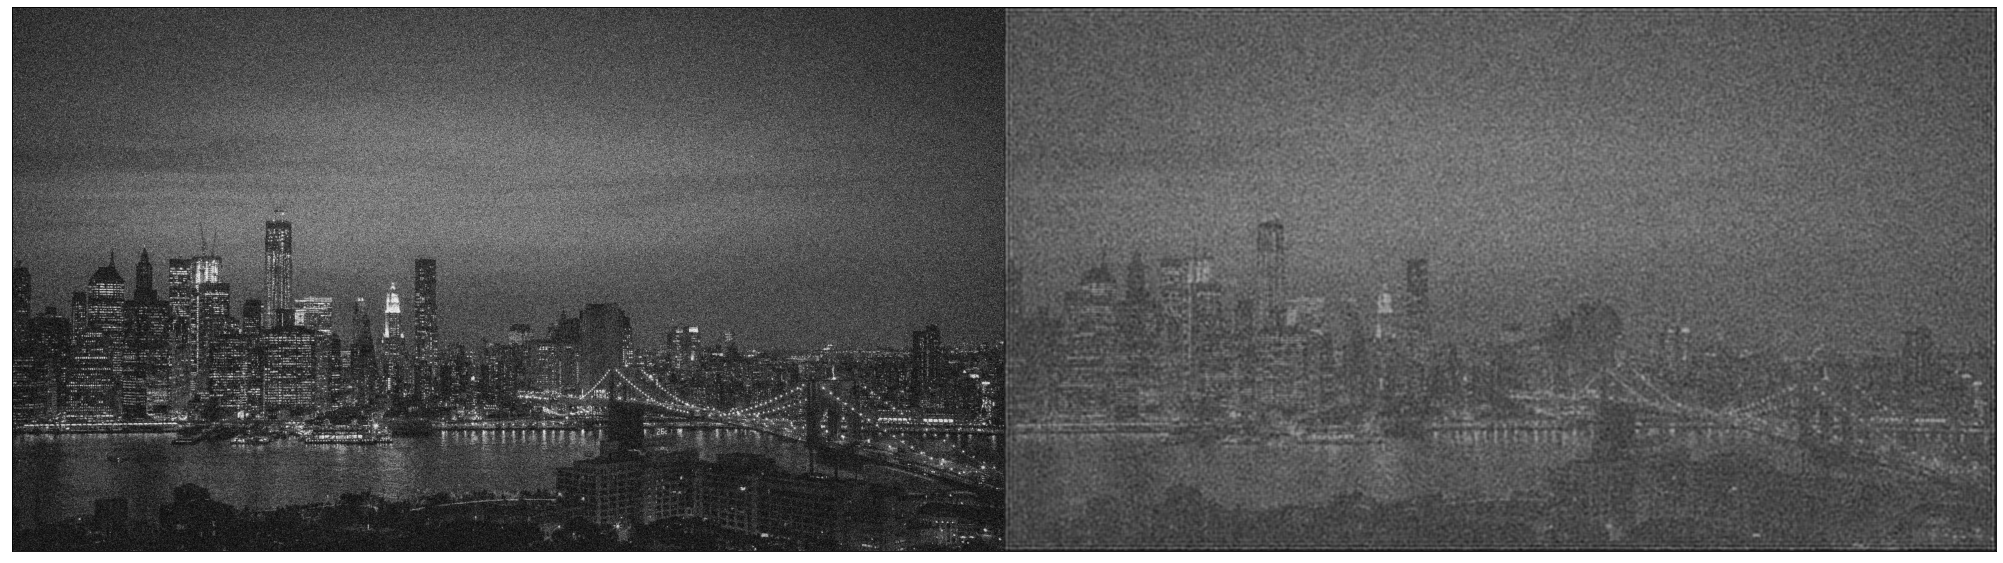

In [2182]:
kernel = np.ones((15,15),np.float64)
print(kernel)
if use_graph:
    image_filtered = skimage.img_as_float64(image_noised_all)
    image_filtered = scipy.signal.convolve2d(image_filtered, kernel, 'same')
    image_filtered = skimage.restoration.wiener(image_filtered, kernel, 5.1e4)
    image_filtered = skimage.img_as_ubyte(image_filtered)
    image_filtered = cv2.hconcat([images_noised[image_name], image_filtered])
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image_filtered, cv2.COLOR_GRAY2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()